<a href="https://colab.research.google.com/github/thiago2608santana/Natural_Language_Processing_with_Python/blob/main/Chat_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar bibliotecas

In [85]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import device
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

# Escolher se o modelo será treinado novamente ou se será carregado o arquivo de um modelo treinado previamente

In [86]:
carregar_modelo_treinado = 'sim'

# Carregar os dados

In [87]:
with open('/content/drive/MyDrive/NLP_with_Python_Datasets/train_qa.txt', 'rb') as f:
  train_data = pickle.load(f)

In [88]:
with open('/content/drive/MyDrive/NLP_with_Python_Datasets/test_qa.txt', 'rb') as f:
  test_data = pickle.load(f)

# Visualizar e entender os dados

In [89]:
type(train_data)

list

In [90]:
type(test_data)

list

In [91]:
len(train_data)

10000

In [92]:
len(test_data)

1000

**story**

In [93]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

**question**

In [94]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

**answer**

In [95]:
train_data[0][2]

'no'

# Preprocessamento dos dados

In [96]:
all_data = test_data + train_data

In [97]:
len(all_data)

11000

In [98]:
vocab = set()

for story, question, answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [99]:
vocab.add('no')

In [100]:
vocab.add('yes')

In [101]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [102]:
vocab_size = len(vocab) + 1

In [103]:
vocab_size

38

**Longest story**

In [104]:
all_story_lens = [len(data[0]) for data in all_data]

In [105]:
max_story_len = max(all_story_lens)

In [106]:
max_story_len

156

**Longets question**

In [107]:
max_question_len = max([len(data[1]) for data in all_data])

In [108]:
max_question_len

6

# Tokenizar o dataset

In [109]:
tokenizer = Tokenizer(filters=[])

In [110]:
tokenizer.fit_on_texts(vocab)

In [111]:
tokenizer.word_index

{'garden': 1,
 'journeyed': 2,
 'bathroom': 3,
 'yes': 4,
 'football': 5,
 'got': 6,
 'no': 7,
 'left': 8,
 'picked': 9,
 'the': 10,
 'grabbed': 11,
 'up': 12,
 '?': 13,
 'put': 14,
 '.': 15,
 'to': 16,
 'hallway': 17,
 'is': 18,
 'there': 19,
 'discarded': 20,
 'john': 21,
 'moved': 22,
 'back': 23,
 'daniel': 24,
 'in': 25,
 'apple': 26,
 'dropped': 27,
 'kitchen': 28,
 'mary': 29,
 'sandra': 30,
 'took': 31,
 'down': 32,
 'went': 33,
 'office': 34,
 'milk': 35,
 'bedroom': 36,
 'travelled': 37}

In [112]:
train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answers.append(answer)

In [113]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

# Função que vetoriza os dados (story, question, answer)

In [114]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):

  #Stories = X
  X = []
  #Questions = Xq
  Xq = []
  #Correct answer (yes/no) = Y
  Y = []

  for story, query, answer in data:

    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in query]

    y = np.zeros(len(word_index)+1)
    y[word_index[answer]] = 1

    X.append(x)
    Xq.append(xq)
    Y.append(y)

  return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

# Vetorizar os dados

In [115]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [116]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [117]:
inputs_test

array([[ 0,  0,  0, ..., 10, 36, 15],
       [ 0,  0,  0, ..., 10,  1, 15],
       [ 0,  0,  0, ..., 10,  1, 15],
       ...,
       [ 0,  0,  0, ..., 10, 26, 15],
       [ 0,  0,  0, ..., 10,  1, 15],
       [ 0,  0,  0, ..., 26, 19, 15]], dtype=int32)

In [118]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Verificar a quantidade de yes/no e checar a posição (index) correspondente. Tudo ok**

In [119]:
tokenizer.word_index['yes']

4

In [120]:
tokenizer.word_index['no']

7

In [121]:
sum(answers_test)

array([  0.,   0.,   0.,   0., 497.,   0.,   0., 503.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

**PLACEHOLDER shape=(max_story_len, batch_size)**

In [122]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

**Input Encoder M**

In [123]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))
#Output: (samples, story_maxlen, embedding_dim)

**Input Encoder C**

In [124]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
#Output: (samples, story_maxlen, max_question_len)

In [125]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))
#Output: (samples, query_maxlen, embedding_dim)

**ENCODED <--- ENCODER (INPUT)**

In [126]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [127]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [128]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [129]:
answer = concatenate([response, question_encoded])

In [130]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [131]:
answer = LSTM(32)(answer)

In [132]:
answer = Dropout(0.5)(answer)

In [133]:
answer = Dense(vocab_size)(answer)
#(samples, vocab_size) # YES/NO

In [134]:
answer = Activation('softmax')(answer)

In [135]:
model = Model([input_sequence, question], answer)

In [136]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, None, 64)     2432        ['input_3[0][0]']                
                                                                                                  
 sequential_5 (Sequential)      (None, 6, 64)        2432        ['input_4[0][0]']                
                                                                                            

# Treinar o modelo

In [138]:
if carregar_modelo_treinado == 'nao':
  with device('/device:GPU:0'):
    history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 8s 17ms/step - loss: 0.9646 - accuracy: 0.4857 - val_loss: 0.6946 - val_accuracy: 0.4960
Epoch 2/100
313/313 [==============================] - 5s 14ms/step - loss: 0.7071 - accuracy: 0.4954 - val_loss: 0.6960 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6973 - accuracy: 0.4987 - val_loss: 0.6941 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6953 - accuracy: 0.4994 - val_loss: 0.6943 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6948 - accuracy: 0.5016 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 6/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6953 - accuracy: 0.4935 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6951 - accuracy: 0.4864 - val_loss: 0.6955 - val_accuracy: 0

# Salvar o modelo treinado

In [139]:
if carregar_modelo_treinado == 'nao':
  filename = '/content/drive/MyDrive/NLP_with_Python_Datasets/chatbot_100_epochs.h5'
  model.save(filename)
  pickle.dump(history, open('/content/drive/MyDrive/NLP_with_Python_Datasets/best_model_history.pickle', 'wb'))

# Carregar um modelo já treinado previamente

In [140]:
if carregar_modelo_treinado == 'sim':
  model.load_weights('/content/drive/MyDrive/NLP_with_Python_Datasets/chatbot_100_epochs.h5')
  history = pickle.load(open('/content/drive/MyDrive/NLP_with_Python_Datasets/best_model_history.pickle', 'rb'))

# Avaliar os resultados do modelo

## Plotar o hitórico de treinamento

In [141]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


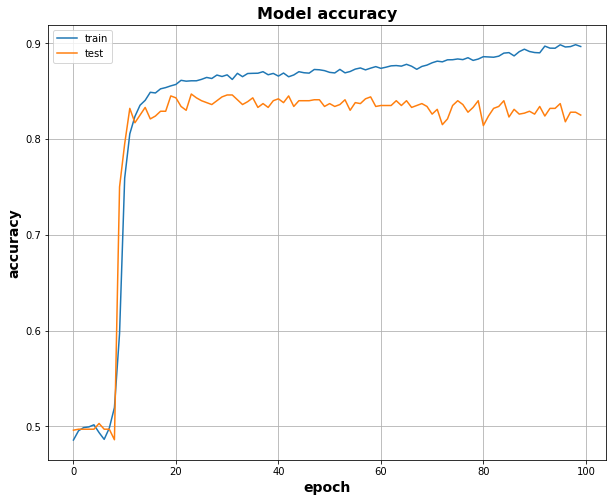

In [142]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=16, fontweight='bold')
plt.ylabel('accuracy', fontsize=14, fontweight='bold')
plt.xlabel('epoch', fontsize=14, fontweight='bold')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

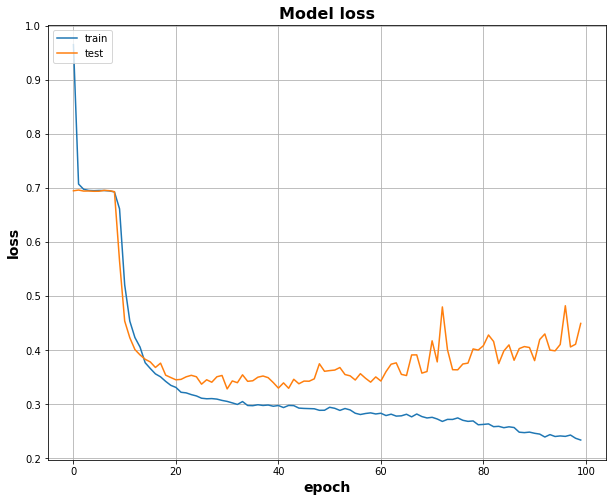

In [143]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=16, fontweight='bold')
plt.ylabel('loss', fontsize=14, fontweight='bold')
plt.xlabel('epoch', fontsize=14, fontweight='bold')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

In [144]:
pred_results = model.predict(([inputs_test, queries_test]))

**Visualizar os dados preditos**

In [145]:
pred_results.shape

(1000, 38)

In [146]:
pred_results[0]

array([5.2955133e-17, 5.9334545e-17, 5.6039190e-17, 7.8028900e-17,
       1.5890280e-06, 5.0881789e-17, 6.0842966e-17, 9.9999845e-01,
       6.6366156e-17, 7.0346033e-17, 3.9600332e-17, 7.8427588e-17,
       5.3635589e-17, 5.5259271e-17, 5.3203781e-17, 8.4364852e-17,
       7.1155155e-17, 5.8995322e-17, 4.8329261e-17, 4.1821345e-17,
       5.8117915e-17, 3.8523366e-17, 5.5580820e-17, 6.8082947e-17,
       5.8133883e-17, 5.0116266e-17, 8.7205734e-17, 6.7713852e-17,
       4.9313130e-17, 8.3398831e-17, 6.0976102e-17, 5.2447311e-17,
       4.4941067e-17, 7.0730811e-17, 6.1248860e-17, 7.7224933e-17,
       5.7855791e-17, 4.9280221e-17], dtype=float32)

In [147]:
val_max = np.argmax(pred_results[0])

In [148]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [149]:
k

'no'

**Comparação com o primeiro registro de treino**

In [150]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [151]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [152]:
test_data[0][2]

'no'

In [153]:
pred_results[0][val_max]

0.99999845

# Criar uma história própria e avaliar o modelo

**Vale ressaltar que o modelo foi treinado em um conjunto específico de vocabulário. As palavras a serem utilizadas na nova história precisam estar nesse vocabulário.**

In [154]:
my_story = 'John left the kitchen . Sandra dropped the football in the garden . '

In [155]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [156]:
my_question = 'Is the football in the garden ?'

In [157]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [158]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

## Montar um dataset que contém o mesmo padrão de formato do dataset de treinamento

In [159]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [160]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [161]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 21,
         8, 10, 28, 15, 30, 27, 10,  5, 25, 10,  1, 15]], dtype=int32)

In [162]:
my_ques

array([[10,  5, 25, 10,  1, 13]], dtype=int32)

In [163]:
my_ans

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

# Predizer o resultado com base no novo texto elaborado

In [164]:
my_pred_results = model.predict(([my_story, my_ques]))

In [165]:
my_val_max = np.argmax(my_pred_results[0])

In [166]:
for key, val in tokenizer.word_index.items():
  if val == my_val_max:
    k = key

In [167]:
k

'yes'

In [168]:
my_pred_results[0][my_val_max]

0.9999666